In [50]:
!pip install deepface opencv-python matplotlib scikit-image scipy

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# 1. 필요한 라이브러리 불러오기
import os
from deepface import DeepFace
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
# 가족 사진 파일 경로 설정 (Google Drive 내 경로로 수정)
family_images = {
    "father": "/content/drive/My Drive/Face/images/test1.png",  # 본인의 이미지 경로로 변경
    "mother": "/content/drive/My Drive/Face/images/test2.png",
    "child": "/content/drive/My Drive/Face/images/test3.png",
    "sibling": "/content/drive/My Drive/Face/images/test4.png"
}

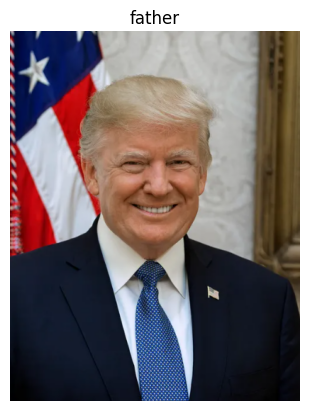

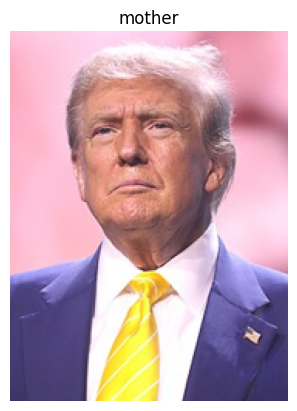

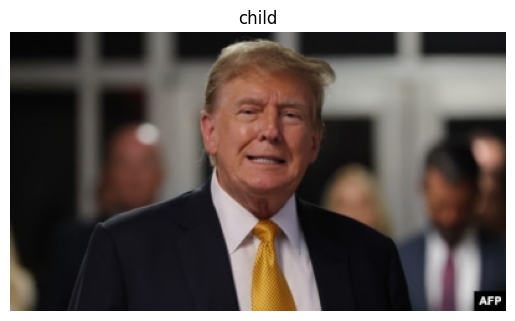

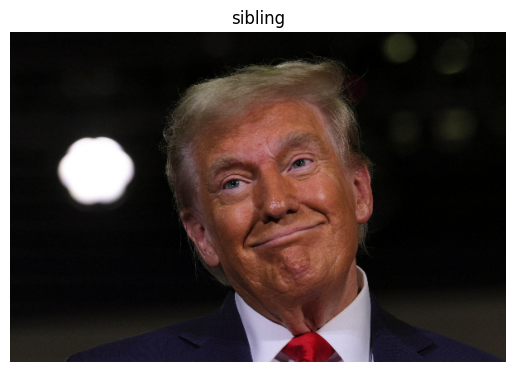

In [54]:
# 이미지 로드 및 확인
for role, path in family_images.items():
    img = cv2.imread(path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(role)
    plt.axis('off')
    plt.show()

In [55]:
def detect_and_preprocess_opencv(image_path, target_size=(224, 224), cascade_path="haarcascade_frontalface_default.xml", margin=0.1):
    """
    얼굴 감지 및 크롭 후 리사이즈 (크롭 범위 확장 포함)
    Args:
        image_path (str): 이미지 경로
        target_size (tuple): 최종 이미지 크기 (width, height)
        cascade_path (str): Haarcascade 모델 경로
        margin (float): 감지된 얼굴 영역 확장 비율 (0~1)
    Returns:
        np.ndarray: 전처리된 이미지
    """
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print(f"No face detected in {image_path}")
        return None

    # 첫 번째 얼굴 선택
    x, y, w, h = faces[0]

    # 크롭 영역 확장
    margin_w, margin_h = int(w * margin), int(h * margin)
    x_start = max(0, x - margin_w)  # 이미지 경계를 초과하지 않도록
    y_start = max(0, y - margin_h)
    x_end = min(img.shape[1], x + w + margin_w)
    y_end = min(img.shape[0], y + h + margin_h)

    # 확장된 영역 크롭 및 리사이즈
    crop_img = img[y_start:y_end, x_start:x_end]
    resized_img = cv2.resize(crop_img, target_size, interpolation=cv2.INTER_AREA)
    return resized_img


# 저장 디렉토리 확인
output_dir = "/content/drive/My Drive/Face/metric_test_processed_images"
if not os.path.exists(output_dir):
    print(f"Creating output directory: {output_dir}")
    os.makedirs(output_dir, exist_ok=True)

# 전처리 및 저장
target_size = (224, 224)  # 전역 변수로 선언
for role, path in family_images.items():
    print(f"Processing {role}'s image: {path}")
    if not os.path.exists(path):
        print(f"File not found: {path}. Skipping {role}.")
        continue

    processed_img = detect_and_preprocess_opencv(path, target_size)  # target_size 전달
    if processed_img is not None:
        output_path = os.path.join(output_dir, f"{role}.jpg")
        cv2.imwrite(output_path, processed_img)
        print(f"Saved preprocessed image for {role} at {output_path}")
    else:
        print(f"Skipping {role} due to face detection failure.")


Processing father's image: /content/drive/My Drive/Face/images/test1.png
Saved preprocessed image for father at /content/drive/My Drive/Face/metric_test_processed_images/father.jpg
Processing mother's image: /content/drive/My Drive/Face/images/test2.png
Saved preprocessed image for mother at /content/drive/My Drive/Face/metric_test_processed_images/mother.jpg
Processing child's image: /content/drive/My Drive/Face/images/test3.png
Saved preprocessed image for child at /content/drive/My Drive/Face/metric_test_processed_images/child.jpg
Processing sibling's image: /content/drive/My Drive/Face/images/test4.png
Saved preprocessed image for sibling at /content/drive/My Drive/Face/metric_test_processed_images/sibling.jpg


Processing father.jpg's image: /content/drive/My Drive/Face/metric_test_processed_images/father.jpg


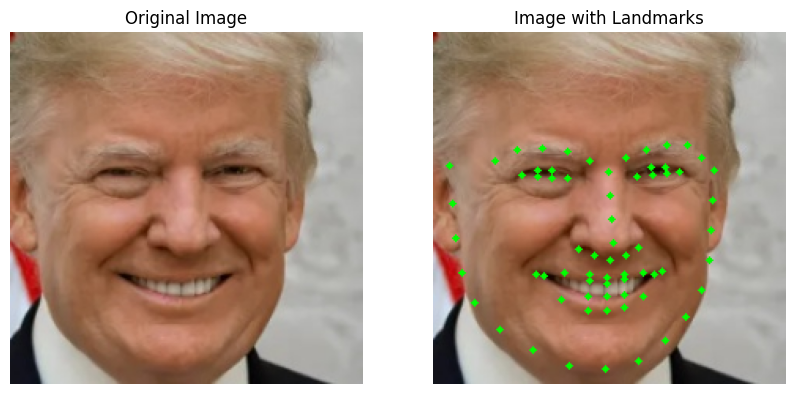

Saved landmarked image at /content/drive/My Drive/Face/landmarked_images/father_landmarks.jpg
Processing mother.jpg's image: /content/drive/My Drive/Face/metric_test_processed_images/mother.jpg


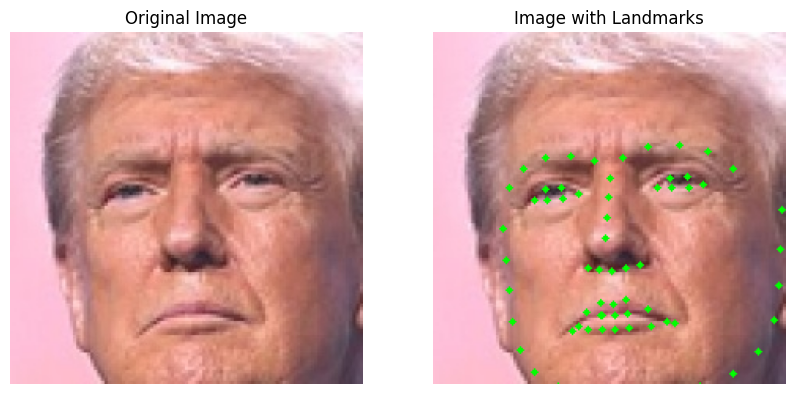

Saved landmarked image at /content/drive/My Drive/Face/landmarked_images/mother_landmarks.jpg
Processing child.jpg's image: /content/drive/My Drive/Face/metric_test_processed_images/child.jpg


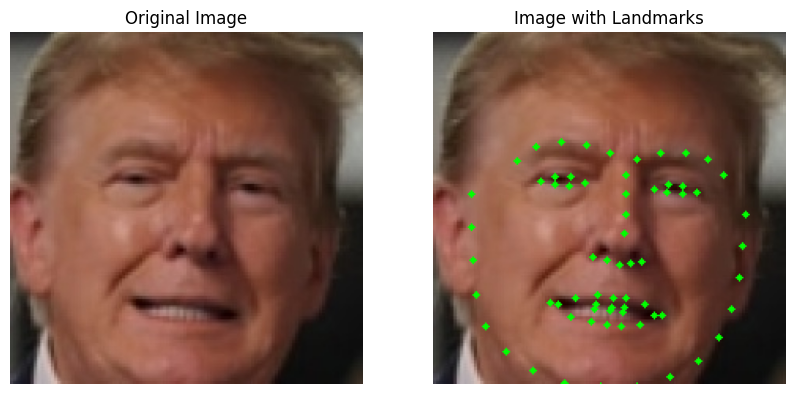

Saved landmarked image at /content/drive/My Drive/Face/landmarked_images/child_landmarks.jpg
Processing sibling.jpg's image: /content/drive/My Drive/Face/metric_test_processed_images/sibling.jpg


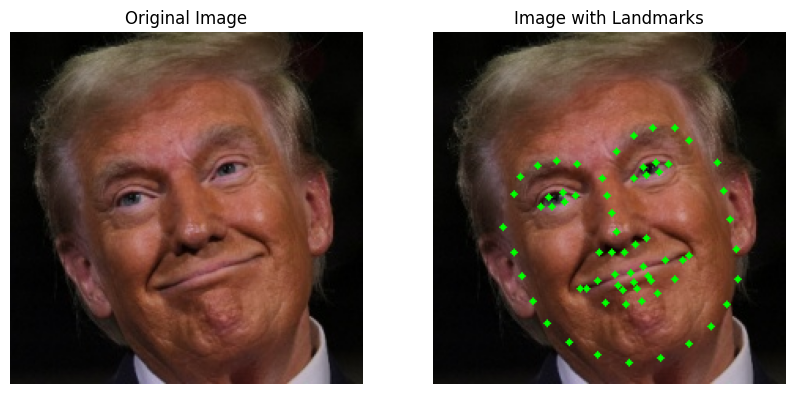

Saved landmarked image at /content/drive/My Drive/Face/landmarked_images/sibling_landmarks.jpg


In [56]:
import cv2
import dlib
import os
import numpy as np
import matplotlib.pyplot as plt

# dlib의 얼굴 감지기 및 랜드마크 예측기 초기화
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/My Drive/Face/landmark_model/shape_predictor_68_face_landmarks.dat")  # 모델 경로 지정

def draw_landmarks(image, landmarks):
    """
    이미지에 랜드마크 점을 그립니다.
    """
    for i in range(landmarks.shape[0]):
        x, y = landmarks[i]
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  # 랜드마크 점 그리기 (초록색)
    return image

def process_and_draw_landmarks(image_path):
    """
    전처리된 이미지를 불러와 랜드마크를 감지하고 그려줍니다.
    랜드마크 좌표 (numpy 배열)를 반환합니다.
    """
    # 이미지 로드
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # 흑백 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 얼굴 감지
    faces = detector(gray)
    if len(faces) == 0:
        print(f"No face detected in {image_path}. Saving for debugging.")
        debug_output_path = os.path.join("/content/drive/My Drive/Face/debug_images", os.path.basename(image_path))
        cv2.imwrite(debug_output_path, img)
        return None

    # 첫 번째 얼굴에 대한 랜드마크만 반환 (가정: 1명만 있는 이미지)
    landmarks = predictor(gray, faces[0])

    # 랜드마크를 numpy 배열로 변환
    landmarks_array = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(landmarks.num_parts)])

    # 랜드마크 시각화 및 저장
    img_with_landmarks = draw_landmarks(img.copy(), landmarks_array)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_with_landmarks, cv2.COLOR_BGR2RGB))
    plt.title("Image with Landmarks")
    plt.axis("off")
    plt.show()

    # 랜드마크 이미지 저장
    output_path = os.path.join("/content/drive/My Drive/Face/landmarked_images", f"{os.path.splitext(os.path.basename(image_path))[0]}_landmarks.jpg")
    cv2.imwrite(output_path, img_with_landmarks)
    print(f"Saved landmarked image at {output_path}")

    return landmarks_array

# 전처리된 이미지 디렉토리
processed_dir = "/content/drive/My Drive/Face/metric_test_processed_images"

# 디렉토리 내 이미지 처리
os.makedirs("/content/drive/My Drive/Face/debug_images", exist_ok=True)
os.makedirs("/content/drive/My Drive/Face/landmarked_images", exist_ok=True)

for role in os.listdir(processed_dir):
    if not role.lower().endswith((".jpg", ".jpeg", ".png")):
        print(f"Skipping non-image file: {role}")
        continue
    image_path = os.path.join(processed_dir, role)
    print(f"Processing {role}'s image: {image_path}")
    process_and_draw_landmarks(image_path)


In [57]:
from deepface import DeepFace
import os
import cv2
import json

# 가족 구성원의 전처리된 이미지 경로
processed_dir = "/content/drive/My Drive/Face/metric_test_processed_images"

def get_embedding(image_path, model_name="VGG-Face"):
    """
    이미지 경로를 받아 DeepFace로 얼굴 임베딩을 생성합니다.

    Args:
        image_path (str): 이미지 파일 경로
        model_name (str): DeepFace 모델 이름 (기본값: "VGG-Face")

    Returns:
        list: DeepFace에서 생성된 임베딩 벡터
    """
    try:
        embedding = DeepFace.represent(img_path=image_path, model_name=model_name, enforce_detection=False)
        if embedding and "embedding" in embedding[0]:
            return embedding[0]["embedding"]
        else:
            raise ValueError(f"Invalid embedding returned for {image_path}")
    except Exception as e:
        raise RuntimeError(f"Error generating embedding for {image_path}: {e}")

# 전처리된 이미지를 사용해 임베딩 생성
embeddings = {}
os.makedirs("/content/drive/My Drive/Face/failed_images", exist_ok=True)

for role in os.listdir(processed_dir):
    if not role.lower().endswith((".jpg", ".jpeg", ".png")):
        print(f"Skipping non-image file: {role}")
        continue

    image_path = os.path.join(processed_dir, role)
    role_name = os.path.splitext(role)[0]  # 역할 이름에서 확장자 제거
    print(f"Generating embedding for {role_name}'s image: {image_path}")

    try:
        if cv2.imread(image_path) is None:
            raise FileNotFoundError(f"Image file could not be read: {image_path}")

        embeddings[role_name] = get_embedding(image_path)
        print(f"Embedding generated successfully for {role_name}.")
    except Exception as e:
        print(f"Failed to generate embedding for {role_name}: {e}")
        failed_path = os.path.join("/content/drive/My Drive/Face/failed_images", role)
        try:
            cv2.imwrite(failed_path, cv2.imread(image_path))
        except Exception as write_error:
            print(f"Failed to save failed image for {role_name}: {write_error}")

# 생성된 임베딩 저장
output_path = "/content/drive/My Drive/Face/embeddings_test.json"
try:
    with open(output_path, "w") as f:
        json.dump(embeddings, f)
    print(f"Embeddings saved at {output_path}")
except Exception as e:
    print(f"Failed to save embeddings to {output_path}: {e}")

# 생성된 임베딩 출력
print("Generated Embeddings:")
for role, embedding in embeddings.items():
    print(f"{role}: {embedding[:5]}...")  # 임베딩의 앞 5개 값만 출력

Generating embedding for father's image: /content/drive/My Drive/Face/metric_test_processed_images/father.jpg
Embedding generated successfully for father.
Generating embedding for mother's image: /content/drive/My Drive/Face/metric_test_processed_images/mother.jpg
Embedding generated successfully for mother.
Generating embedding for child's image: /content/drive/My Drive/Face/metric_test_processed_images/child.jpg
Embedding generated successfully for child.
Generating embedding for sibling's image: /content/drive/My Drive/Face/metric_test_processed_images/sibling.jpg
Embedding generated successfully for sibling.
Embeddings saved at /content/drive/My Drive/Face/embeddings_test.json
Generated Embeddings:
father: [0.0, 0.0, 0.0, 0.0, 0.0]...
mother: [0.0, 0.0, 0.0, 0.0, 0.0]...
child: [0.0, 0.0, 0.0, 0.0, 0.0]...
sibling: [0.0, 0.0, 0.0, 0.0, 0.0]...


In [58]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
import cv2  # `calculate_ssim_similarity`에서 사용
import dlib  # `landmarks_to_numpy` 입력 검증용

# 가중치 설정
weights = {
    "feature_distribution": 0.2,  # 이목구비의 분포
    "eye_color": 0.05,            # 눈동자 색
    "nose_shape": 0.15,            # 코의 모양
    "mouth_shape": 0.15,           # 입의 모양
    "eye_position_ratio": 0.15,    # 눈 위치 비율
    "nose_position_ratio": 0.15,   # 코 위치 비율
    "mouth_position_ratio": 0.15  # 입 위치 비율
}

# 유사도 계산 함수들
def calculate_cosine_similarity(embedding1, embedding2):
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    if embedding1.ndim != 1 or embedding2.ndim != 1:
        raise ValueError("Embeddings must be 1-dimensional arrays.")
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)
    return cosine_similarity(embedding1, embedding2)[0][0]


def calculate_rgb_similarity(rgb1, rgb2):
    if len(rgb1) != len(rgb2):
        raise ValueError("RGB values must have the same length.")
    diff = np.linalg.norm(np.array(rgb1) - np.array(rgb2))
    return 1 - (diff / 255)  # 정규화


def calculate_ssim_similarity(image1, image2):
    try:
        gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        return ssim(gray1, gray2)
    except Exception as e:
        raise RuntimeError(f"Error calculating SSIM: {e}")


def landmarks_to_numpy(landmarks):
    if not isinstance(landmarks, dlib.full_object_detection):
        raise TypeError("Input must be a dlib.full_object_detection object.")
    num_points = landmarks.num_parts
    return np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(num_points)])


def calculate_lip_curvature_similarity(landmarks1, landmarks2):
    if landmarks1.shape[0] < 60 or landmarks2.shape[0] < 60:
        raise ValueError("Landmark arrays must have at least 60 points.")
    top_curve_diff = np.linalg.norm(landmarks1[48:54] - landmarks2[48:54], axis=1).mean()
    bottom_curve_diff = np.linalg.norm(landmarks1[54:60] - landmarks2[54:60], axis=1).mean()
    max_possible_diff = 1000
    normalized_top = top_curve_diff / max_possible_diff
    normalized_bottom = bottom_curve_diff / max_possible_diff
    similarity = 1 - (normalized_top + normalized_bottom) / 2
    return max(0, min(similarity, 1))


def calculate_position_ratio_similarity(landmarks1, landmarks2, position_index, max_diff=0.2, debug=False):
    def position_ratio(landmarks, position_index):
        forehead = landmarks[27]
        chin = landmarks[8]
        face_length = np.linalg.norm(forehead - chin)
        if face_length == 0:
            raise ValueError("Invalid face length: forehead and chin landmarks are identical.")
        position = landmarks[position_index]
        return (position[1] - forehead[1]) / face_length

    ratio1 = position_ratio(landmarks1, position_index)
    ratio2 = position_ratio(landmarks2, position_index)
    diff = abs(ratio1 - ratio2)
    similarity = 1 - (diff / max_diff)
    similarity = max(0, min(similarity, 1))
    if debug:
        print(f"Position Index: {position_index}, Ratio1: {ratio1:.4f}, Ratio2: {ratio2:.4f}, Diff: {diff:.4f}, Similarity: {similarity:.4f}")
    return similarity


def calculate_eye_position_ratio_similarity(landmarks1, landmarks2, max_diff=0.2, debug=False):
    return calculate_position_ratio_similarity(landmarks1, landmarks2, position_index=36, max_diff=max_diff, debug=debug)


def calculate_nose_position_ratio_similarity(landmarks1, landmarks2, max_diff=0.2, debug=False):
    return calculate_position_ratio_similarity(landmarks1, landmarks2, position_index=30, max_diff=max_diff, debug=debug)


def calculate_mouth_position_ratio_similarity(landmarks1, landmarks2, max_diff=0.2, debug=False):
    return calculate_position_ratio_similarity(landmarks1, landmarks2, position_index=51, max_diff=max_diff, debug=debug)


In [59]:
# 키 이름 수정: .jpg 확장자 제거
embeddings_cleaned = {os.path.splitext(role)[0]: embedding for role, embedding in embeddings.items()}

# 수정된 딕셔너리 확인
print("Cleaned Embeddings dictionary content:")
for role, embedding in embeddings_cleaned.items():
    print(f"{role}: Embedding length = {len(embedding)}")

# 예제 임베딩 및 이미지 데이터
roles = ["father", "mother", "child", "sibling"]
eye_colors = {
    "father": [34, 45, 67],
    "mother": [33, 44, 66],
    "child": [34, 46, 68],
    "sibling": [35, 47, 70]
}

# 전처리된 이미지 로드 및 랜드마크 감지
processed_images_dir = "/content/drive/My Drive/Face/metric_test_processed_images"
face_images = {}
landmarks_detected = {}

for role in roles:
    image_path = os.path.join(processed_images_dir, f"{role}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image for {role} at {image_path}.")
        continue

    face_images[role] = image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        landmarks_detected[role] = predictor(gray, faces[0])  # 첫 번째 얼굴 랜드마크 감지
        print(f"Landmarks detected for {role}.")
    else:
        print(f"No faces detected for {role}.")

# 메트릭별 유사도 계산
similarities = {}

# 유사도 계산 함수 호출 (중복 제거)
def calculate_similarities(role1, role2):
    """
    두 역할(role1, role2)의 모든 유사도를 계산하여 similarities 딕셔너리에 추가합니다.
    """
    if role1 not in embeddings_cleaned or role2 not in embeddings_cleaned:
        print(f"Missing embeddings for {role1} or {role2}. Skipping similarity calculation.")
        return

    similarities[f"feature_distribution_{role1}"] = calculate_cosine_similarity(
        embeddings_cleaned[role1], embeddings_cleaned[role2]
    )
    similarities[f"eye_color_{role1}"] = calculate_rgb_similarity(eye_colors[role1], eye_colors[role2])
    if role1 in face_images and role2 in face_images:
        similarities[f"nose_shape_{role1}"] = calculate_ssim_similarity(
            face_images[role1], face_images[role2]
        )
    if role1 in landmarks_detected and role2 in landmarks_detected:
        # 입술 곡률 유사도 계산
        similarities[f"mouth_shape_{role1}"] = calculate_lip_curvature_similarity(
            landmarks_to_numpy(landmarks_detected[role1]), landmarks_to_numpy(landmarks_detected[role2])
        )
        # 눈 위치 비율 유사도 계산
        similarities[f"eye_position_ratio_{role1}"] = calculate_eye_position_ratio_similarity(
            landmarks_to_numpy(landmarks_detected[role1]), landmarks_to_numpy(landmarks_detected[role2])
        )
        # 코 위치 비율 유사도 계산
        similarities[f"nose_position_ratio_{role1}"] = calculate_nose_position_ratio_similarity(
            landmarks_to_numpy(landmarks_detected[role1]), landmarks_to_numpy(landmarks_detected[role2])
        )
        # 입 위치 비율 유사도 계산
        similarities[f"mouth_position_ratio_{role1}"] = calculate_mouth_position_ratio_similarity(
            landmarks_to_numpy(landmarks_detected[role1]), landmarks_to_numpy(landmarks_detected[role2])
        )

# 각 관계별 유사도 계산
calculate_similarities("father", "child")
calculate_similarities("mother", "child")
calculate_similarities("sibling", "child")

# 결과 출력
print("Calculated Similarities:")
for metric, value in similarities.items():
    print(f"{metric}: {value:.4f}")


Cleaned Embeddings dictionary content:
father: Embedding length = 4096
mother: Embedding length = 4096
child: Embedding length = 4096
sibling: Embedding length = 4096
Landmarks detected for father.
Landmarks detected for mother.
Landmarks detected for child.
Landmarks detected for sibling.
Calculated Similarities:
feature_distribution_father: 0.4039
eye_color_father: 0.9945
nose_shape_father: 0.3360
mouth_shape_father: 0.9844
eye_position_ratio_father: 0.9318
nose_position_ratio_father: 0.5711
mouth_position_ratio_father: 0.7897
feature_distribution_mother: 0.5162
eye_color_mother: 0.9882
nose_shape_mother: 0.3088
mouth_shape_mother: 0.9918
eye_position_ratio_mother: 0.6381
nose_position_ratio_mother: 0.9864
mouth_position_ratio_mother: 0.9752
feature_distribution_sibling: 0.2999
eye_color_sibling: 0.9904
nose_shape_sibling: 0.2551
mouth_shape_sibling: 0.9739
eye_position_ratio_sibling: 0.3973
nose_position_ratio_sibling: 0.9525
mouth_position_ratio_sibling: 0.6131


In [60]:
# 가중치를 적용한 종합 유사도 계산
def calculate_weighted_similarity(metrics, weights):
    """
    가중치를 적용하여 종합 유사도를 계산합니다.

    Args:
        metrics (dict): 유사도 메트릭 딕셔너리
        weights (dict): 가중치 딕셔너리

    Returns:
        float: 가중치를 적용한 종합 유사도 점수
    """
    total_weighted_similarity = 0
    for metric, value in metrics.items():
        weight = weights.get(metric, 0)
        if weight > 0:
            total_weighted_similarity += value * weight
        else:
            print(f"Warning: Metric '{metric}' has no weight. Ignored in calculation.")
    return total_weighted_similarity

# 유사도 계산을 위한 관계별 데이터
relations = {
    "Father-Child": {
        "feature_distribution": similarities.get("feature_distribution_father", 0),
        "eye_color": similarities.get("eye_color_father", 0),
        "nose_shape": similarities.get("nose_shape_father", 0),
        "mouth_shape": similarities.get("mouth_shape_father", 0),
        "eye_position_ratio": similarities.get("eye_position_ratio_father", 0),
        "nose_position_ratio": similarities.get("nose_position_ratio_father", 0),  # 추가
        "mouth_position_ratio": similarities.get("mouth_position_ratio_father", 0)  # 추가
    },
    "Mother-Child": {
        "feature_distribution": similarities.get("feature_distribution_mother", 0),
        "eye_color": similarities.get("eye_color_mother", 0),
        "nose_shape": similarities.get("nose_shape_mother", 0),
        "mouth_shape": similarities.get("mouth_shape_mother", 0),
        "eye_position_ratio": similarities.get("eye_position_ratio_mother", 0),
        "nose_position_ratio": similarities.get("nose_position_ratio_mother", 0),  # 추가
        "mouth_position_ratio": similarities.get("mouth_position_ratio_mother", 0)  # 추가
    },
    "Sibling-Child": {
        "feature_distribution": similarities.get("feature_distribution_sibling", 0),
        "eye_color": similarities.get("eye_color_sibling", 0),
        "nose_shape": similarities.get("nose_shape_sibling", 0),
        "mouth_shape": similarities.get("mouth_shape_sibling", 0),
        "eye_position_ratio": similarities.get("eye_position_ratio_sibling", 0),
        "nose_position_ratio": similarities.get("nose_position_ratio_sibling", 0),  # 추가
        "mouth_position_ratio": similarities.get("mouth_position_ratio_sibling", 0)  # 추가
    }
}

# 각 관계별 최종 유사도 점수 계산
final_scores = {
    relation: calculate_weighted_similarity(metrics, weights)
    for relation, metrics in relations.items()
}

# 최종 결과 출력
print("Final Similarity Scores:")
for relation, score in final_scores.items():
    print(f"{relation}: {score:.2f}")


Final Similarity Scores:
Father-Child: 0.67
Mother-Child: 0.74
Sibling-Child: 0.59


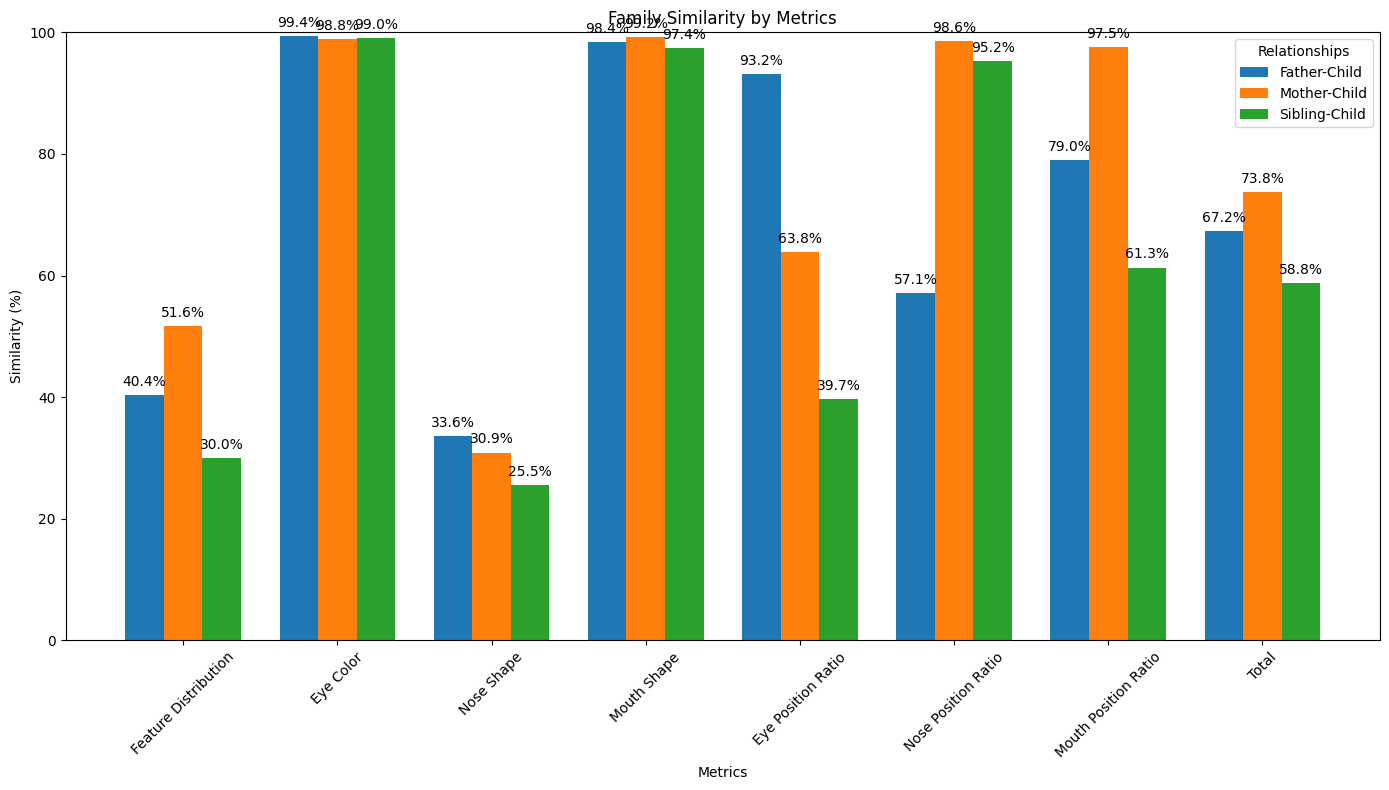

In [61]:
# 부모 및 형제와 자녀 간의 최종 점수 및 메트릭별 점수 저장
similarity_scores = {
    "Father-Child": {
        "total": final_scores["Father-Child"],
        "feature_distribution": similarities["feature_distribution_father"],
        "eye_color": similarities["eye_color_father"],
        "nose_shape": similarities["nose_shape_father"],
        "mouth_shape": similarities["mouth_shape_father"],
        "eye_position_ratio": similarities["eye_position_ratio_father"],
        "nose_position_ratio": similarities["nose_position_ratio_father"],  # 추가
        "mouth_position_ratio": similarities["mouth_position_ratio_father"]  # 추가
    },
    "Mother-Child": {
        "total": final_scores["Mother-Child"],
        "feature_distribution": similarities["feature_distribution_mother"],
        "eye_color": similarities["eye_color_mother"],
        "nose_shape": similarities["nose_shape_mother"],
        "mouth_shape": similarities["mouth_shape_mother"],
        "eye_position_ratio": similarities["eye_position_ratio_mother"],
        "nose_position_ratio": similarities["nose_position_ratio_mother"],  # 추가
        "mouth_position_ratio": similarities["mouth_position_ratio_mother"]  # 추가
    },
    "Sibling-Child": {
        "total": final_scores["Sibling-Child"],
        "feature_distribution": similarities["feature_distribution_sibling"],
        "eye_color": similarities["eye_color_sibling"],
        "nose_shape": similarities["nose_shape_sibling"],
        "mouth_shape": similarities["mouth_shape_sibling"],
        "eye_position_ratio": similarities["eye_position_ratio_sibling"],
        "nose_position_ratio": similarities["nose_position_ratio_sibling"],  # 추가
        "mouth_position_ratio": similarities["mouth_position_ratio_sibling"]  # 추가
    }
}

# 시각화를 위한 데이터 준비
categories = [
    "Feature Distribution",
    "Eye Color",
    "Nose Shape",
    "Mouth Shape",
    "Eye Position Ratio",
    "Nose Position Ratio",  # 추가
    "Mouth Position Ratio",  # 추가
    "Total"
]
relationships = ["Father-Child", "Mother-Child", "Sibling-Child"]

# 점수 배열
scores = {
    category: [similarity_scores[relation][category.lower().replace(" ", "_")] * 100 for relation in relationships]
    if category != "Total" else [similarity_scores[relation]["total"] * 100 for relation in relationships]
    for category in categories
}

# 그래프 설정
x = np.arange(len(categories))  # 카테고리별 위치
width = 0.25  # 막대 너비

# Bar plot 생성
fig, ax = plt.subplots(figsize=(14, 8))

# 각 관계별로 막대 생성
for i, relation in enumerate(relationships):
    ax.bar(x + (i - 1) * width, [scores[category][i] for category in categories], width, label=relation)

# 그래프 꾸미기
ax.set_xlabel("Metrics")
ax.set_ylabel("Similarity (%)")
ax.set_title("Family Similarity by Metrics")
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.set_ylim(0, 100)
ax.legend(title="Relationships")

# 각 막대 위에 점수 표시
for i, relation in enumerate(relationships):
    for j, category in enumerate(categories):
        score = scores[category][i]
        ax.text(x[j] + (i - 1) * width, score + 1, f"{score:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()
